<a href="https://colab.research.google.com/github/DomMc97/Weather-Predictions/blob/main/LSTM%20Model/LSTM_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Time Series Data Forcasting

In this notebook I use an LSTM model to predict the minimum daily temperatures in the city Melbourne, Australia. Using a univariate dataset of the minimum daily temperatures over 10 years (1981-1990) in Melbourne from the Australian Bureau of Meteorology.

## Set Up 

Imports libaries.

In [1]:
# data analytics library
import pandas as pd

# mathematical library
import numpy as np

# sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# keras deep learing library
from keras.models import Sequential
from keras.layers import Dense, LSTM

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets design of figures

## Load Data

Loads in the df of temperatures from github.

In [2]:
# load csv from github url
temp_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/' +
                      'master/daily-min-temperatures.csv')
N, M = temp_df.shape
print('Columns: ', M, '\nRows:', N)
temp_df.head()

Columns:  2 
Rows: 3650


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


# Plot Data

A plot of the minimum temperatures dataset.

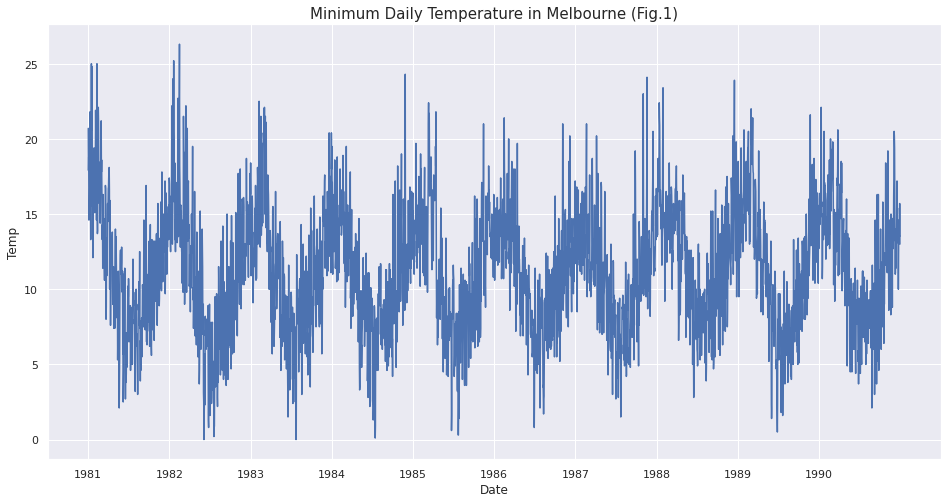

In [3]:
fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(x='Date', y='Temp', data=temp_df)
ax.set_title('Minimum Daily Temperature in Melbourne (Fig.1)', fontsize=15)
years = pd.date_range(start='1981-01-01', end='1990-01-01',freq='AS')
ax.set_xticks(years.strftime('%Y-%m-%d'))
ax.set_xticklabels(years.strftime('%Y'))
plt.show()

## LSTM

### Overview
The Long Short-Term Memory (LSTM) network is a Recurrent Neural Network (RNN), networks with loops in them which allows information to persist, that is trained using Backpropagation.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

### Memory Blocks
An LSTM is of the form of a standard NN but instead of having neurons, LSTMs networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

1. **Forget Gate:** conditionally decides what information to throw away from the block.
2. **Input Gate:** conditionally decides which values from the input to update the memory state.
3. **Output Gate:** conditionally decides what to output based on input and the memory of the block.
Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

### Full Explanation

This article [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) has a full article on exactly how memory blocks work.


---



## Window LSTM

To turn a time-series dataset, $X_{t}$, into a regression problem we can use a sliding window.  Were the descriptors for a prediction at time $t$ for a window of size $p$ are the values $\{X_{t - 1}, X_{t- 2} \dots X_{t-p}\}$. For example the series $\{X_{t} : t \in \mathbb{R}_{[0, 5]}\} = \{10, 20, 30, 50, 60\}$ with $p = 3$ would produce the following dataset:

$x_{1}$ | $x_{2}$ | $x_{3}$ | $y$
-|-|-|-
10| 20 | 30 | 50
20 | 30 | 50 | 60

### $p=5$

I will initial choose a window of $p=5$ to capture short term auto-regressive patterns.

In [4]:
def create_Xy(col, p=5):
    """ Converts time-series data into descriptor and target dataset where the 
    descriptors are the previous p values and the target is the next value in 
    the time series to predict.
    Inputs:
      col: column of time series data.
      p: the lookback parameter.
    Outputs:
      X: descriptor dataframe.
      y: target dataframe.
    """
    # len of time series
    N = len(col)

    # a temporary array to hold the data
    arr = np.zeros((N - p, p + 1))

    # sliding window
    for i in range(N - p):
        arr[i, :] = col[i: i + p + 1]
    # X and y arrays
    X, y = arr[:, :p], arr[:, p:] 

    return X, y

In [5]:
# create X and y with a window of 5
p = 5
X, y = create_Xy(temp_df['Temp'], p)

Create a test train split.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    shuffle=False)

Before I train the LSTM I will normalize the data since LSTMs are sensitive to the scale of the input data.

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Keras LSTM expects an input of a 3D array of the form (number of samples, p, number of features)

In [8]:
# reshape the data to 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

I will now create a LSTM using keras.

In [9]:
%%time
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(p, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
3280/3280 [==============================] - 8s 2ms/step - loss: 60.6593
Epoch 2/100
3280/3280 [==============================] - 6s 2ms/step - loss: 13.4446
Epoch 3/100
3280/3280 [==============================] - 6s 2ms/step - loss: 9.2097
Epoch 4/100
3280/3280 [==============================] - 6s 2ms/step - loss: 8.0119
Epoch 5/100
3280/3280 [==============================] - 6s 2ms/step - loss: 7.9650
Epoch 6/100
3280/3280 [==============================] - 6s 2ms/step - loss: 7.3429
Epoch 7/100
3280/3280 [==============================] - 6s 2ms/step - loss: 7.0358
Epoch 8/100
3280/3280 [==============================] - 6s 2ms/step - loss: 7.1300
Epoch 9/100
3280/3280 [==============================] - 6s 2ms/step - loss: 6.5373
Epoch 10/100
3280/3280 [==============================] - 6s 2ms/step - loss: 6.1068
Epoch 11/100
3280/3280 [==============================] - 6s 2ms/step - loss: 6.4356
Epoch 12/100
3280/3280 [==============================] - 6s 2ms/step - 

I will now visualise the predictions.

MSE of predictions:  5.188825199619328 



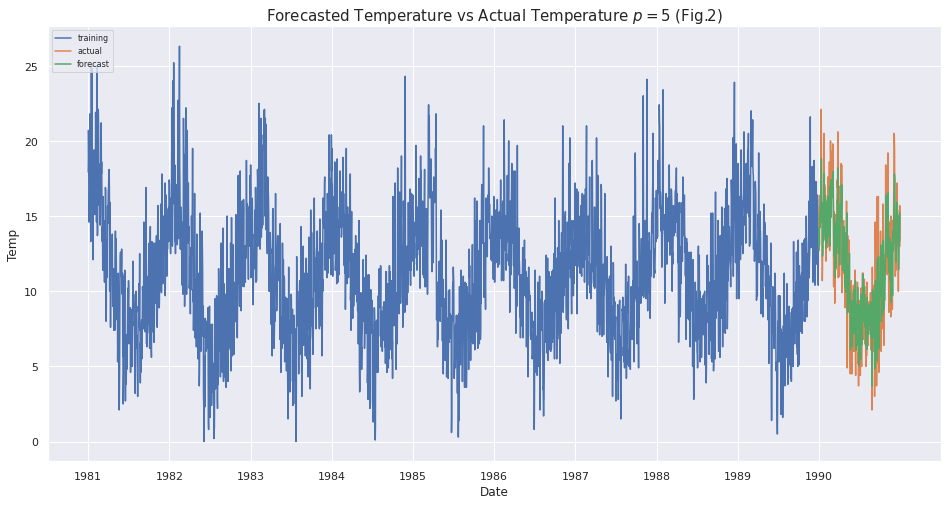

In [10]:
# Forecast
pred = model.predict(X_test)

# print MSE
print('MSE of predictions: ', mean_squared_error(y_test, pred),'\n')

# plots
plt.figure(figsize=(16,8))
plt.plot(temp_df['Temp'][:len(y_train)+p], label='training')
plt.plot(temp_df['Temp'][len(y_train)+p:], label='actual')
plt.plot(range(3650-len(y_test), 3650), pred, label='forecast')

# configure plots
years = pd.date_range(start='1981-01-01', end='1990-01-01',freq='AS')
plt.xticks(range(0, 3650, 365),years.strftime('%Y'))
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title(r'Forecasted Temperature vs Actual Temperature $p=5$ (Fig.2)',
          fontsize=15)
plt.legend(loc='upper left', fontsize=8)

# display plots
plt.show()

### $p=365$

I will now repeat the above model with $p=365$ to predict yearly trends.

In [11]:
# create X and y with a window of 5
p = 365
X, y = create_Xy(temp_df['Temp'], p)

Create a test train split.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    shuffle=False)

Before I train the LSTM I will normalize the data since LSTMs are sensitive to the scale of the input data.

In [13]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Keras LSTM expects an input of a 3D array of the form (number of samples, p, number of features)

In [14]:
# reshape the data to 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

I will now create a LSTM using keras. With a reduction to 50 epochs due to the increase in complexity of $p$ increasing from 5 to 365. 

In [15]:
%%time
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(p, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
2956/2956 [==============================] - 116s 39ms/step - loss: 74.3804
Epoch 2/50
2956/2956 [==============================] - 117s 40ms/step - loss: 15.8065
Epoch 3/50
2956/2956 [==============================] - 116s 39ms/step - loss: 9.1995
Epoch 4/50
2956/2956 [==============================] - 117s 39ms/step - loss: 7.8860
Epoch 5/50
2956/2956 [==============================] - 115s 39ms/step - loss: 7.5128
Epoch 6/50
2956/2956 [==============================] - 115s 39ms/step - loss: 6.7625
Epoch 7/50
2956/2956 [==============================] - 116s 39ms/step - loss: 7.0951
Epoch 8/50
2956/2956 [==============================] - 115s 39ms/step - loss: 6.3577
Epoch 9/50
2956/2956 [==============================] - 116s 39ms/step - loss: 6.4206
Epoch 10/50
2956/2956 [==============================] - 116s 39ms/step - loss: 5.9826
Epoch 11/50
2956/2956 [==============================] - 115s 39ms/step - loss: 5.9508
Epoch 12/50
2956/2956 [===========================

I will now visualise the predictions.

MSE of predictions:  5.03175660688027 



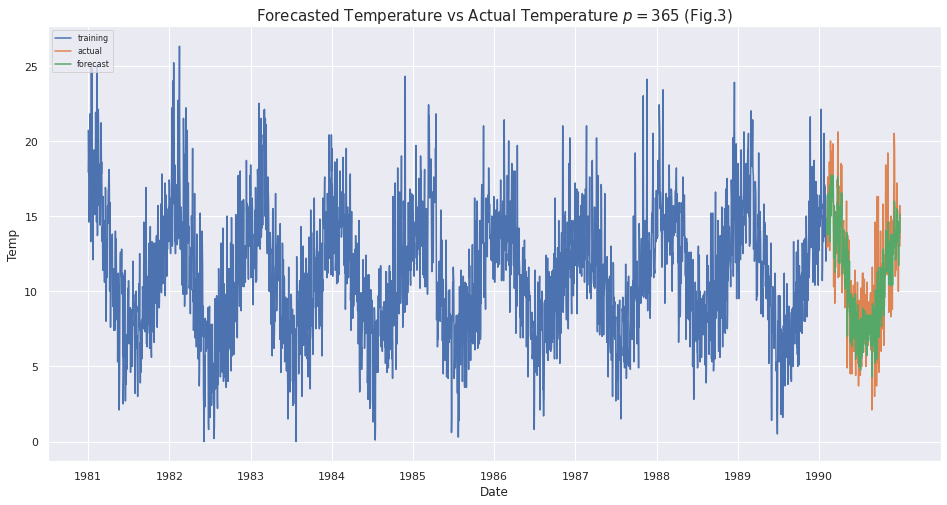

In [16]:
# Forecast
pred = model.predict(X_test)

# print MSE
print('MSE of predictions: ', mean_squared_error(y_test, pred),'\n')

# plots
plt.figure(figsize=(16,8))
plt.plot(temp_df['Temp'][:len(y_train)+p], label='training')
plt.plot(temp_df['Temp'][len(y_train)+p:], label='actual')
plt.plot(range(3650-len(y_test), 3650), pred, label='forecast')

# configure plots
years = pd.date_range(start='1981-01-01', end='1990-01-01',freq='AS')
plt.xticks(range(0, 3650, 365),years.strftime('%Y'))
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title(r'Forecasted Temperature vs Actual Temperature $p=365$ (Fig.3)',
          fontsize=15)
plt.legend(loc='upper left', fontsize=8)

# display plots
plt.show()

We can see that the predictions for $p=365$ are better than that of $p=5$ but not by enough to justify the increase in computational complexity.

## Multi Step LSTM

A multi-step approach can be used to predict multiple days of weather. For example the next weeks weather this is done via the prediction of a vector not a single float. To do this we again create a dataset from the timeseries. For example the series $\{X_{t} : t \in \mathbb{R}_{[0, 5]}\} = \{10, 20, 30, 50, 60\}$ with $p = 2$ and a predict of $d=2$ following values would produce the following dataset:

$x_{1}$ | $x_{2}$ | $y_{1}$ | $y_{2}$ |
-|-|-|-
10| 20 | 30 | 50
20 | 30 | 50 | 60




### $p=7$ and $d=7$

I will firstly predict the next weeks weather from the previous weeks weather.

In [17]:
# an updated version which includes multiple days of predictions
def create_Xy(col, p, d=0):
    """ Converts time-series data into descriptor and target dataset where the 
    descriptors are the previous p values and the target is the next value in 
    the time series to predict.
    Inputs:
      col: column of time series data.
      p: the lookback parameter.
      d: the days forward to search
    Outputs:
      X: descriptor dataframe.
      y: target dataframe.
    """
    # len of time series
    N = len(col)

    # a temporary array to hold the data
    arr = np.zeros((N - p - d, p + d))

    # sliding window
    for i in range(N - p - d):
        arr[i, :] = col[i: i + p + d]
    # X and y arrays
    X, y = arr[:, :p], arr[:, p:] 

    return X, y, arr

In [18]:
# create X and y with a window of 5
p = 7
d = 7
X, y, arr = create_Xy(temp_df['Temp'], p, d)

Create a test train split.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    shuffle=False)

Before I train the LSTM I will normalize the data since LSTMs are sensitive to the scale of the input data.

In [20]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Keras LSTM expects an input of a 3D array of the form (number of samples, p, number of features)

In [21]:
# reshape the data to 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

I will now create a LSTM using keras.

In [22]:
%%time
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(p, 1)))
model.add(Dense(d))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1)

Epoch 1/100
3272/3272 [==============================] - 10s 2ms/step - loss: 79.1297
Epoch 2/100
3272/3272 [==============================] - 8s 2ms/step - loss: 16.4737
Epoch 3/100
3272/3272 [==============================] - 7s 2ms/step - loss: 9.9850
Epoch 4/100
3272/3272 [==============================] - 6s 2ms/step - loss: 9.0803
Epoch 5/100
3272/3272 [==============================] - 7s 2ms/step - loss: 9.0104
Epoch 6/100
3272/3272 [==============================] - 6s 2ms/step - loss: 8.7453
Epoch 7/100
3272/3272 [==============================] - 6s 2ms/step - loss: 8.6088
Epoch 8/100
3272/3272 [==============================] - 6s 2ms/step - loss: 8.6536
Epoch 9/100
3272/3272 [==============================] - 6s 2ms/step - loss: 8.9232
Epoch 10/100
3272/3272 [==============================] - 6s 2ms/step - loss: 8.8414
Epoch 11/100
3272/3272 [==============================] - 6s 2ms/step - loss: 8.6684
Epoch 12/100
3272/3272 [==============================] - 6s 2ms/step -

I will now visualise the weekly predictions for the next year.

MSE of predictions:  7.079163394578048 



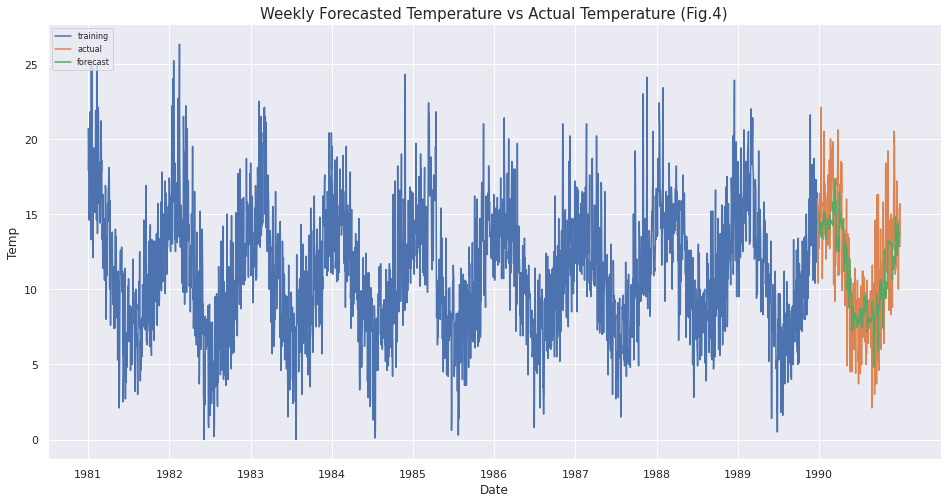

In [23]:
# Forecast
pred = model.predict(X_test)

# weekly predictions
weekly_pred = pred[::d].flatten()

# print MSE
print('MSE of predictions: ', mean_squared_error(y_test, pred),'\n')

# plots
plt.figure(figsize=(16,8))
plt.plot(temp_df['Temp'][:len(y_train)+p], label='training')
plt.plot(temp_df['Temp'][len(y_train)+p:], label='actual')
plt.plot(range(3650 - len(weekly_pred), 3650), weekly_pred, label='forecast')

# configure plots
years = pd.date_range(start='1981-01-01', end='1990-01-01',freq='AS')
plt.xticks(range(0, 3650, 365),years.strftime('%Y'))
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title(r'Weekly Forecasted Temperature vs Actual Temperature (Fig.4)',
          fontsize=15)
plt.legend(loc='upper left', fontsize=8)

# display plots
plt.show()

### $p=365$ and $d=365$

I will now predict the next years weather from the previous years weather.

In [24]:
# create X and y with a window of 5
p = 365
d = 365
X, y, arr = create_Xy(temp_df['Temp'], p, d)

Create a test train split.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    shuffle=False)

Before I train the LSTM I will normalize the data since LSTMs are sensitive to the scale of the input data.

In [26]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Keras LSTM expects an input of a 3D array of the form (number of samples, p, number of features)

In [27]:
# reshape the data to 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

I will now create a LSTM using keras.

In [28]:
%%time
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(p, 1)))
model.add(Dense(d))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
2628/2628 [==============================] - 104s 39ms/step - loss: 85.4424
Epoch 2/50
2628/2628 [==============================] - 103s 39ms/step - loss: 17.3397
Epoch 3/50
2628/2628 [==============================] - 106s 40ms/step - loss: 15.7831
Epoch 4/50
2628/2628 [==============================] - 112s 43ms/step - loss: 15.6910
Epoch 5/50
2628/2628 [==============================] - 103s 39ms/step - loss: 15.7507
Epoch 6/50
2628/2628 [==============================] - 102s 39ms/step - loss: 15.7714
Epoch 7/50
2628/2628 [==============================] - 104s 39ms/step - loss: 15.7913
Epoch 8/50
2628/2628 [==============================] - 102s 39ms/step - loss: 15.8118
Epoch 9/50
2628/2628 [==============================] - 103s 39ms/step - loss: 15.7704
Epoch 10/50
2628/2628 [==============================] - 103s 39ms/step - loss: 15.8638
Epoch 11/50
2628/2628 [==============================] - 103s 39ms/step - loss: 15.8420
Epoch 12/50
2628/2628 [==================

I will now visualise the next years predictions.

MSE of predictions:  12.101945507703677 



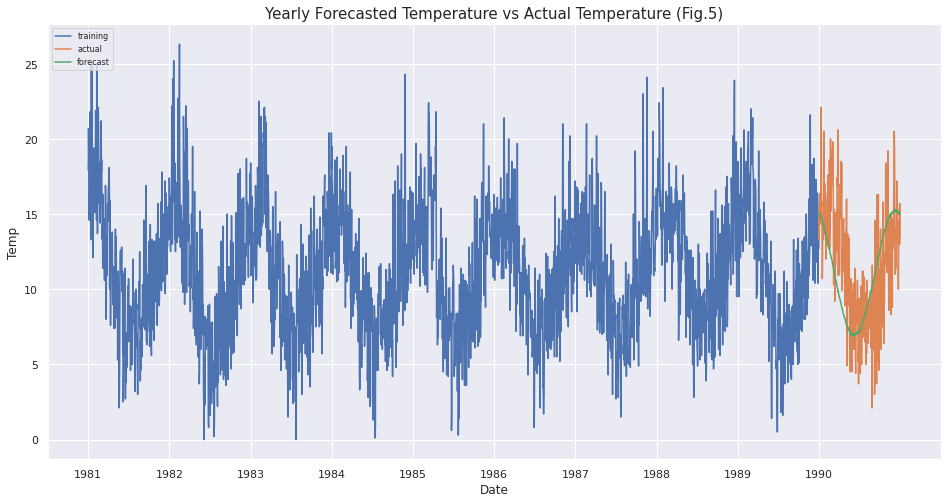

In [29]:
# Forecast
pred = model.predict(X_test)

samples = np.array([X[-365]])

samples = np.reshape(samples, (samples.shape[0], samples.shape[1], 1))

pred_samples = model.predict(samples)

# weekly predictions
yearly_pred = pred_samples.flatten()

# print MSE
print('MSE of predictions: ', mean_squared_error(y_test, pred),'\n')

# plots
plt.figure(figsize=(16,8))
plt.plot(temp_df['Temp'][:3650-365], label='training')
plt.plot(temp_df['Temp'][3650-365:], label='actual')
plt.plot(range(3650 - len(yearly_pred), 3650), yearly_pred, label='forecast')

# configure plots
years = pd.date_range(start='1981-01-01', end='1990-01-01',freq='AS')
plt.xticks(range(0, 3650, 365),years.strftime('%Y'))
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title(r'Yearly Forecasted Temperature vs Actual Temperature (Fig.5)',
          fontsize=15)
plt.legend(loc='upper left', fontsize=8)

# display plots
plt.show()